In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *

In [3]:
args = load_args('../nn_configs/B/42-resnet_cmip.yml')

In [4]:
args['train_years'] = ['2000', '2000']
args['valid_years'] = ['2001', '2001']
args['test_years'] = ['2002', '2002']

In [5]:
args['cmip_dir'] = '/data/stephan/WeatherBench/CMIP/MPI-ESM/5.625deg/'

In [ ]:
dg_train1, dg_valid1, dg_test1 = load_data(**args)

In [ ]:
args['cmip_dir'] = '/data/stephan/WeatherBench/CMIP/MIROC6/5.625deg/'

In [ ]:
dg_train2, dg_valid2, dg_test2 = load_data(**args)

In [ ]:
dg_train1.mean

In [58]:
dg_train2.mean

<xarray.DataArray 'z' (level: 15)>
array([ 1.00622828e+05,  5.37757025e+04,  1.36190654e+04,  2.19914501e+02,
        2.52147621e+02,  2.75207206e+02,  1.34681897e+01,  6.35267338e+00,
        1.11280969e+00,  3.19886552e-01, -3.32396817e-02, -3.85414295e-01,
        3.37078289e-01,  3.79497583e+02,  0.00000000e+00])
Coordinates:
  * level        (level) float64 250.0 500.0 850.0 250.0 ... 850.0 1.0 1.0 1.0
    level_names  (level) <U9 'z_250' 'z_500' 'z_850' ... 'orography' 'lat2d'

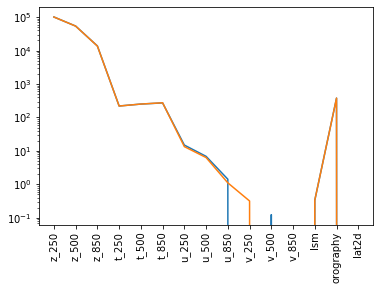

In [48]:
plt.plot(dg_train1.mean)
plt.plot(dg_train2.mean)
plt.yscale('log')
plt.xticks(range(15), dg_train1.mean.level_names.values, rotation=90);

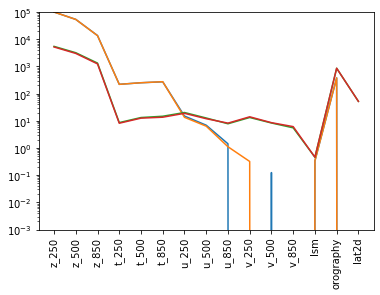

In [56]:
plt.plot(dg_train1.mean)
plt.plot(dg_train2.mean)
plt.plot(dg_train1.std)
plt.plot(dg_train2.std)
plt.yscale('log')
plt.ylim(1e-3, 1e5)
plt.xticks(range(15), dg_train1.mean.level_names.values, rotation=90);

In [60]:
dg_train1.batch_size

64

In [62]:
len(dg_train1), len(dg_train2)

(12, 12)

In [64]:
len(dg_train1.idxs), len(dg_train2.idxs)

(726, 726)

In [66]:
dgs=[dg_train1, dg_train2]

In [73]:
dg_train1[0][0].shape

(64, 32, 64, 15)

In [77]:
class CombinedDataGenerator(keras.utils.Sequence):
    """For now assumes same length"""
    def __init__(self, dgs, batch_size):
        self.dgs = dgs
        self.batch_size = batch_size
        assert batch_size % len(dgs) == 0, 'Batch size % number dgs must be zero.'
        for dg in dgs: dg.batch_size = batch_size // len(dgs)
        
    def __len__(self):
        total_samples = np.sum([len(dg.idxs) for dg in dgs])
        return int(np.ceil(total_samples / self.batch_size))
    
    def __getitem__(self, i):
        Xs = []; ys = []
        for dg in self.dgs:
            X, y = dg[i]
            Xs.append(X); ys.append(y)
        return np.concatenate(Xs), np.concatenate(ys)
    
    def on_epoch_end(self):
        for dg in dgs:
            dg.on_epoch_end()

In [78]:
cdg  = CombinedDataGenerator(dgs, 64)

In [79]:
cdg.dgs[0].batch_size

32

In [80]:
X, y = cdg[0]

In [81]:
X.shape

(64, 32, 64, 15)

In [5]:
len(set([2, 2, 2]))

1

## Implementation

In [6]:
from src.data_generator import *

In [7]:
args = load_args('../nn_configs/B/66-resnet_d3_cmip.yml')

In [8]:
args['train_years'] = ['1850', '1850']
args['valid_years'] = ['1850', '1850']
args['test_years'] = ['1850', '1850']

In [9]:
from copy import copy

In [10]:
bargs = copy(args)

In [11]:
dg_train, dg_valid, dg_test = [], [], []
for cd in args['cmip_dir']:
    bargs['cmip_dir'] = cd
    dgtr, dgv, dgte = load_data(**bargs
    )
    dg_train.append(dgtr); dg_valid.append(dgv); dg_test.append(dgte)


DG start 11:36:46.078579
DG normalize 11:36:46.096084
DG load 11:54:57.689450
Loading data into RAM
DG done 12:00:04.640573
DG start 12:00:04.641005
DG normalize 12:00:04.668103
DG load 12:00:04.679145
Loading data into RAM
DG done 12:00:07.977351
DG start 12:00:07.977554
DG normalize 12:00:07.995192
DG load 12:00:08.000455
Loading data into RAM
DG done 12:00:11.171881
Mean = <xarray.DataArray 'z' (level: 38)>
array([ 1.98857912e+05,  1.00392032e+05,  5.37375122e+04,  4.03468299e+04,
        2.86984280e+04,  1.36530940e+04,  6.98657078e+03,  2.14017499e+02,
        2.19900060e+02,  2.51049567e+02,  2.59389328e+02,  2.65621351e+02,
        2.72094452e+02,  2.74430399e+02,  6.16555943e+00,  1.51722402e+01,
        7.18501536e+00,  5.27803286e+00,  3.68926399e+00,  1.61009619e+00,
        7.15353729e-01,  3.32268009e-01,  1.93880551e-01,  3.66916055e-02,
        6.19816018e-02,  1.13983589e-01,  5.64610548e-03, -1.41256267e-01,
        3.32268009e-01,  1.93880551e-01,  3.66916055e-02,  6.

In [12]:
dg_train2, dg_valid2, dg_test2 = [
    CombinedDataGenerator(dg, 32) for dg in [dg_train, dg_valid, dg_test]]

In [14]:
d = dg_train2.dgs[1].data

In [17]:
a = d.interpolate_na('lon', method='nearest', fill_value='extrapolate')
b = d.interpolate_na('lat', method='nearest', fill_value='extrapolate')

In [19]:
d = xr.concat([a, b], 'tmp')

In [20]:
d = d.mean('tmp')

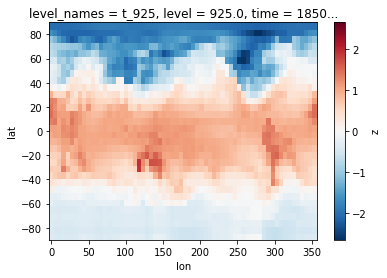

In [36]:
d.isel(time=0, level=13).plot()

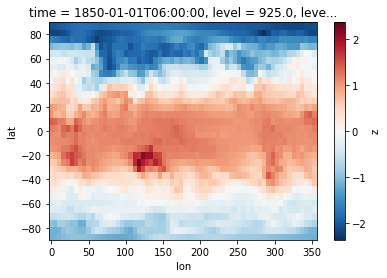

In [37]:
dg_train2.dgs[0].data.isel(time=0, level=13).plot()

In [26]:
dg_train2.dgs[1].data = d

In [27]:
X, y = dg_train2[0]

In [28]:
X.shape, y.shape

((32, 32, 64, 114), (32, 32, 64, 2))

In [29]:
X.mean((1, 2, 3))

array([ 0.04518026,  0.03881834,  0.05680755, -0.00040261,  0.00602937,
        0.04770199,  0.04896388, -0.00907518,  0.05147656, -0.00464988,
        0.02379091,  0.00497371,  0.01048161,  0.01431104, -0.00966827,
       -0.00493075,  0.0608091 ,  0.00423132, -0.01967926, -0.00630518,
       -0.02162616, -0.02656261,  0.05178591, -0.00165312,  0.04006153,
        0.02993794, -0.0232895 ,  0.02701178, -0.02332   ,  0.07368617,
        0.00812666, -0.02713708], dtype=float32)

In [44]:
X, y = dg_test[1][0]

In [45]:
X.shape

(16, 32, 64, 114)

In [46]:
X.mean((1, 2, 3))

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan], dtype=float32)

In [40]:
X.mean((1, 2, 0))

array([-1.88900948e-01,  8.78572986e-02,  9.72015411e-02,             nan,
                   nan,             nan,             nan, -2.42755219e-01,
       -3.75308283e-02,  1.03296213e-01,             nan,             nan,
                   nan,             nan,  2.93859988e-01, -6.96688369e-02,
       -4.42114100e-02,             nan,             nan,             nan,
                   nan, -2.64860597e-02, -3.00238654e-02, -4.80720215e-03,
                   nan,             nan,             nan,             nan,
       -2.64860597e-02, -3.00238654e-02, -4.80720215e-03,             nan,
                   nan,             nan,             nan, -5.51928679e-07,
        2.99509338e-07, -8.00355338e-11, -1.88023642e-01,  8.98252800e-02,
        1.00045033e-01,             nan,             nan,             nan,
                   nan, -2.43102282e-01, -3.69331241e-02,  1.05530210e-01,
                   nan,             nan,             nan,             nan,
        2.95582980e-01, -

In [54]:
dg_test[1].dt

6.0

In [60]:
dd = dg_test[1].data

In [62]:
dd

<xarray.DataArray 'z' (time: 1459, lat: 32, lon: 64, level: 38)>
array([[[[ 0.77748854, -1.060876  , -1.03243589, ...,  1.44426201,
           2.57085561, -1.67874412],
         [ 0.77649026, -1.06125549, -1.02444489, ...,  1.44426201,
           2.63684811, -1.67874412],
         [ 0.7757524 , -1.06173967, -1.01693581, ...,  1.44426201,
           2.70122081, -1.67874412],
         ...,
         [ 0.78068801, -1.06091362, -1.05820072, ...,  1.44426201,
           2.40688572, -1.67874412],
         [ 0.77974553, -1.06057502, -1.04936711, ...,  1.44426201,
           2.47378905, -1.67874412],
         [ 0.77861083, -1.06060119, -1.04081388, ...,  1.44426201,
           2.52247395, -1.67874412]],

        [[ 0.72549106, -1.02226941, -1.02172719, ...,  1.44426201,
           2.06275586, -1.57043805],
         [ 0.7199788 , -1.0349349 , -1.00582844, ...,  1.44426201,
           2.33441714, -1.57043805],
         [ 0.7163205 , -1.04862435, -0.98974714, ...,  1.44426201,
           2.4794585 , -1.57043805],
         ...,
         [ 0.74705023, -1.02522355, -1.0616004 , ...,  1.44426201,
           1.50808802, -1.57043805],
         [ 0.73924379, -1.01911572, -1.04651652, ...,  1.44426201,
           1.76416741, -1.57043805],
         [ 0.7321318 , -1.01646419, -1.03438253, ...,  1.44426201,
           1.87833927, -1.57043805]],

        [[ 0.60924388, -0.99239273, -0.98203799, ...,  1.44426201,
           2.80071523, -1.46213197],
         [ 0.60210709, -1.01620411, -0.97939185, ...,  1.44426201,
           3.12389527, -1.46213197],
         [ 0.6034402 , -1.02471156, -0.97840466, ...,  1.44426201,
           3.37895707, -1.46213197],
         ...,
         [ 0.68852361, -0.95462364, -0.99662828, ...,  1.44426201,
           0.85969458, -1.46213197],
         [ 0.65172978, -0.95585535, -0.99916343, ...,  1.44426201,
           2.03308297, -1.46213197],
         [ 0.62271759, -0.96859281, -0.99411649, ...,  1.44426201,
           2.49159806, -1.46213197]],

        ...,

        [[-2.80832274, -1.35296079, -1.24125764, ..., -0.73436932,
          -0.44150882,  1.46213197],
         [-2.90402142, -1.43107526, -1.31190174, ..., -0.73436932,
          -0.44090151,  1.46213197],
         [-2.98976209, -1.50280872, -1.35765283, ..., -0.73436932,
          -0.44191369,  1.46213197],
         ...,
         [-2.63992306, -1.10324641, -0.92424345, ..., -0.7343693 ,
          -0.435842  ,  1.46213197],
         [-2.66078778, -1.19253621, -1.01243941, ..., -0.73436932,
          -0.44120516,  1.46213197],
         [-2.71509185, -1.27222261, -1.12876304, ..., -0.73436932,
          -0.441104  ,  1.46213197]],

        [[-3.00952311, -1.47395929, -1.34456961, ..., -0.73436932,
          -0.44130638,  1.57043805],
         [-3.03187596, -1.4758093 , -1.36322988, ..., -0.73436932,
          -0.44069907,  1.57043805],
         [-3.05071311, -1.48139697, -1.38045608, ..., -0.73436932,
          -0.44241978,  1.57043805],
         ...,
         [-2.90004689, -1.42496743, -1.32421827, ...,  1.06439006,
          -0.28301559,  1.57043805],
         [-2.9413671 , -1.44621397, -1.31994385, ..., -0.29933311,
          -0.39848176,  1.57043805],
         [-2.97947544, -1.46496275, -1.32800786, ..., -0.73436932,
          -0.44373519,  1.57043805]],

        [[-2.71991585, -1.44892111, -1.2594506 , ..., -0.73436932,
          -0.44130638,  1.67874412],
         [-2.71951282, -1.4446862 , -1.24354016, ..., -0.73436932,
          -0.44110395,  1.67874412],
         [-2.71555069, -1.44197578, -1.22892943, ..., -0.73436932,
          -0.44080029,  1.67874412],
         ...,
         [-2.70252342, -1.46828002, -1.3074068 , ..., -0.73436932,
          -0.43999064,  1.67874412],
         [-2.71105532, -1.46110078, -1.29208488, ..., -0.73436932,
          -0.44191358,  1.67874412],
         [-2.71695821, -1.45450387, -1.27590136, ..., -0.73436932,
          -0.44161007,  1.67874412]]],


       [[[ 0.79785722, -1.04689538, -1.01301625, ...,  1.44426201,
           2

In [6]:
ds = xr.open_dataset('/data/stephan/WeatherBench/CMIP/MIROC6/5.625deg/geopotential/geopotential_185001010600-185101010000_5.625deg.nc')

In [7]:
ds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, plev: 7, time: 1460)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * plev     (plev) float64 9.25e+04 8.5e+04 7e+04 6e+04 5e+04 2.5e+04 5e+03
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1850-01-01T06:00:00 ... 1851-01-01
Data variables:
    z        (time, plev, lat, lon) float32 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-01T19:03:33Z
    data_specs_version:     01.00.31
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              6hrPt
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.MIROC.MIROC6...
    grid:                   native atmosphere T85 Gaussian grid
    grid_label:             gn
    history:                2019-11-01T19:03:33Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            JAMSTEC (Japan Agency for Marine-Earth Science an...
    institution_id:         MIROC
    mip_era:                CMIP6
    nominal_resolution:     250 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       MIROC6
    parent_time_units:      days since 3200-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    source:                 MIROC6 (2017): \naerosol: SPRINTARS6.0\natmos: CC...
    source_id:              MIROC6
    source_type:            AOGCM AER
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               6hrPlevPt
    table_info:             Creation Date:(22 July 2019) MD5:b4cefb4b6dbb146f...
    title:                  MIROC6 output prepared for CMIP6
    variable_id:            zg
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MIROC is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/54f72957-33b4-4bfb-9d6e-ace0f84feb18

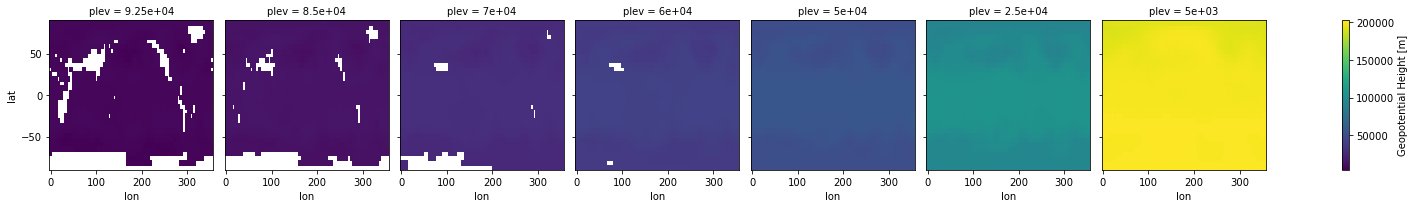

In [8]:
ds.z.isel(time=0).plot(col='plev')

In [10]:
a = ds.z.isel(time=0).load()

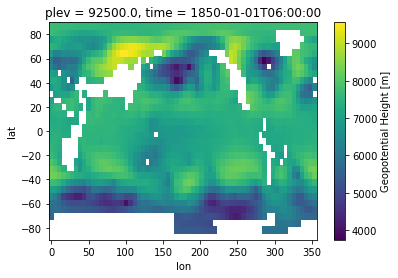

In [12]:
a.isel(plev=0).plot()

In [32]:
b = a.interpolate_na('lon', method='nearest', fill_value='extrapolate')
c = a.interpolate_na('lat', method='nearest', fill_value='extrapolate')

In [ ]:
xr.concat()

In [40]:
d = xr.concat([b, c], 'tmp')

In [43]:
d = d.mean('tmp')

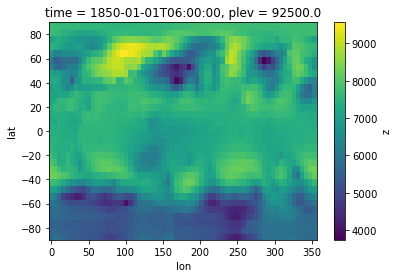

In [44]:
d.isel(plev=0).plot()

In [ ]:
ds.z[:100]

In [68]:
ds = xr.open_dataset('/data/stephan/WeatherBench/CMIP/test/hus_6hrPlevPt_NorESM2-MM_historical_r1i1p1f1_gn_195001010300-195912312100.nc')

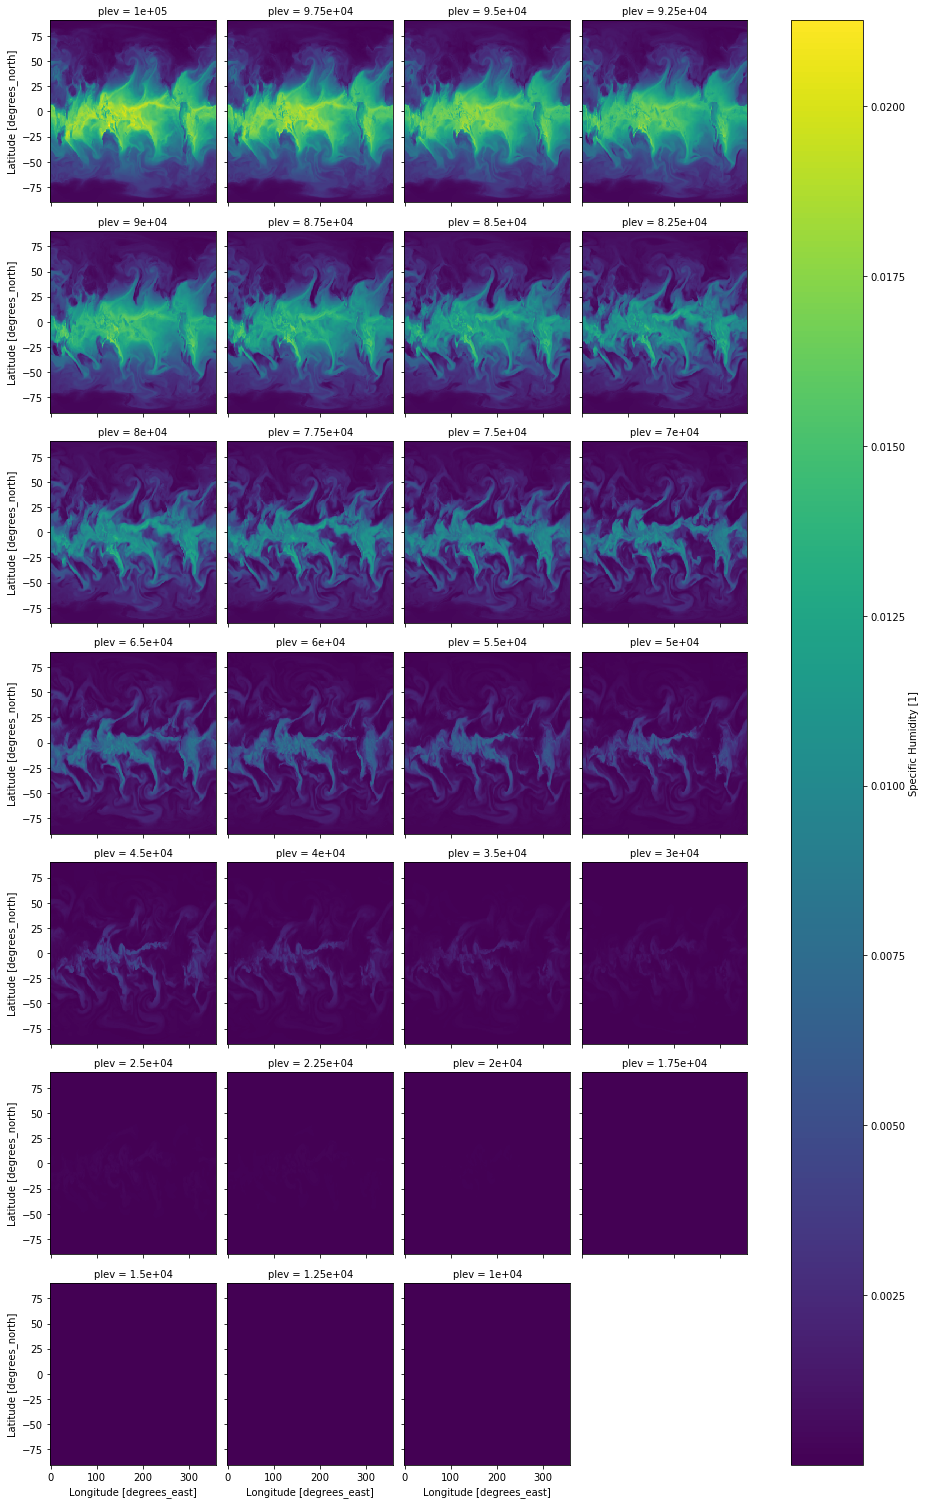

In [72]:
ds.hus.isel(time=0).plot(col='plev', col_wrap=4)

In [71]:
ds

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 192, lon: 288, plev: 27, time: 14600)
Coordinates:
  * time      (time) object 1950-01-01 03:00:00 ... 1959-12-31 21:00:00
  * plev      (plev) float64 1e+05 9.75e+04 9.5e+04 ... 1.5e+04 1.25e+04 1e+04
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 ...
    lon_bnds  (lon, bnds) float64 ...
    hus       (time, plev, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.7 CMIP-6.2
    activity_id:               CMIP
    branch_method:             Hybrid-restart from year 1200-01-01 of piControl
    branch_time:               0.0
    branch_time_in_child:      0.0
    branch_time_in_parent:     438000.0
    contact:                   Please send any requests or bug reports to nor...
    creation_date:             2019-11-29T13:49:35Z
    data_specs_version:        01.00.31
    experiment:                all-forcing simulation of the recent past
    experiment_id:             historical
    external_variables:        areacella
    forcing_index:             1
    frequency:                 6hrPt
    further_info_url:          https://furtherinfo.es-doc.org/CMIP6.NCC.NorES...
    grid:                      finite-volume grid with 0.9x1.25 degree lat/lo...
    grid_label:                gn
    history:                   2019-11-29T13:49:35Z ; CMOR rewrote data to be...
    initialization_index:      1
    institution:               NorESM Climate modeling Consortium consisting ...
    institution_id:            NCC
    mip_era:                   CMIP6
    model_id:                  NorESM2-MM
    nominal_resolution:        100 km
    parent_activity_id:        CMIP
    parent_experiment_id:      piControl
    parent_mip_era:            CMIP6
    parent_source_id:          NorESM2-MM
    parent_sub_experiment_id:  none
    parent_time_units:         days since 0001-01-01
    parent_variant_label:      r1i1p1f1
    physics_index:             1
    product:                   model-output
    realization_index:         1
    realm:                     atmos
    run_variant:               N/A
    source:                    NorESM2-MM (2017): \naerosol: OsloAero\natmos:...
    source_id:                 NorESM2-MM
    source_type:               AOGCM AER BGC
    sub_experiment:            none
    sub_experiment_id:         none
    table_id:                  6hrPlevPt
    table_info:                Creation Date:(24 July 2019) MD5:0bb394a356ef9...
    title:                     NorESM2-MM output prepared for CMIP6
    variable_id:               hus
    variant_label:             r1i1p1f1
    license:                   CMIP6 model data produced by NCC is licensed u...
    cmor_version:              3.5.0
    tracking_id:               hdl:21.14100/8622dea7-13da-4942-8ccf-2c6425f9e4b3

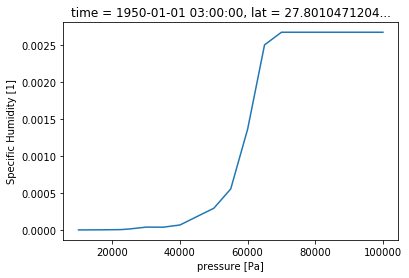

In [78]:
ds.hus.isel(time=0).sel(lat=27.9881, lon=86.9250, method='nearest').plot()

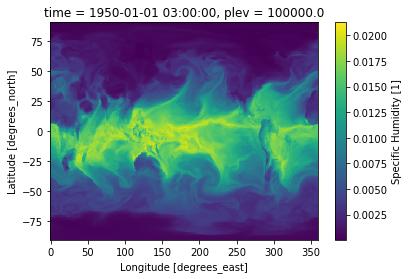

In [84]:
ds.hus.isel(time=0, plev=0).plot()

In [88]:
era = xr.open_dataset('/data/stephan/WeatherBench/5.625deg/geopotential//geopotential_2018_5.625deg.nc')

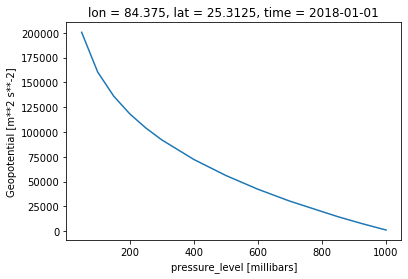

In [89]:
era.z.isel(time=0).sel(lat=27.9881, lon=86.9250, method='nearest').plot()

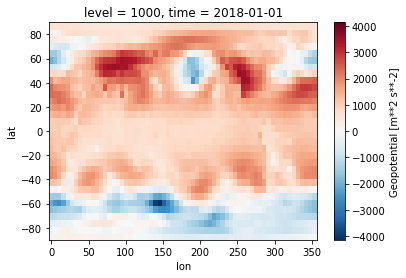

In [90]:
era.z.isel(time=0, level=-1).plot()

In [91]:
ds2 = xr.open_dataset('/data/stephan/WeatherBench/CMIP/MIROC6/5.625deg/geopotential//geopotential_185001010600-185101010000_5.625deg.nc')

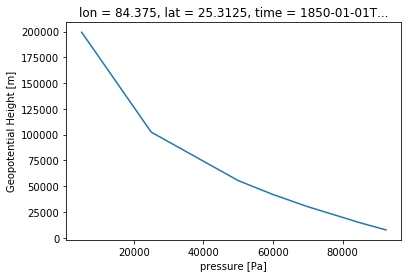

In [92]:
ds2.z.isel(time=0).sel(lat=27.9881, lon=86.9250, method='nearest').plot()

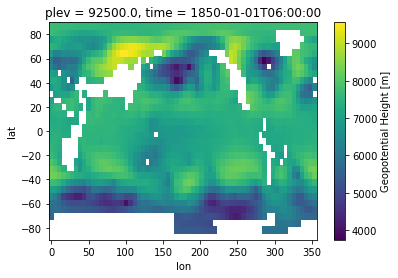

In [93]:
ds2.z.isel(time=0, plev=0).plot()

In [ ]:
a = ds2.z.isel(time=0, plev=0)

In [97]:
ds3 = ds2.z.where(np.isnan(ds2.z), era.z.mean('time'))

In [100]:
ds3

<xarray.DataArray 'z' (time: 1460, plev: 7, lat: 32, lon: 64, level: 13)>
array([[[[[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         [[            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          ...,
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan],
          [            nan,             nan,             nan, ...,
                       nan,             nan,             nan]],

         ...,

         [[ 1.99116922e+05,  1.55791750e+05,  1.30158117e+05, ...,
            1.32327295e+04,  6.73573438e+03,  6.72012756e+02],
          [ 1.99117062e+05,  1.55821938e+05,  1.30204023e+05, ...,
            1.32494453e+04,  6.73994287e+03,  6.55777771e+02],
          [ 1.99090375e+05,  1.55826094e+05,  1.30222367e+05, ...,
            1.32661992e+04,  6.75261084e+03,  6.61516602e+02],
          ...,
          [ 1.98975891e+05,  1.55560062e+05,  1.29892383e+05, ...,
            1.32396328e+04,  6.81269727e+03,  8.76113953e+02],
          [ 1.99045641e+05,  1.55658453e+05,  1.30000703e+05, ...,
            1.32220244e+04,  6.76046875e+03,  7.83939453e+02],
          [ 1.99093391e+05,  1.55736500e+05,  1.30090344e+05, ...,
            1.32223604e+04,  6.74185596e+03,  7.13420715e+02]],

         [[ 1.98522781e+05,  1.55104656e+05,  1.29416344e+05, ...,
            1.31415977e+04,  6.74488672e+03,  8.39372009e+02],
          [ 1.98515484e+05,  1.55114469e+05,  1.29433164e+05, ...,
            1.31384609e+04,  6.73243750e+03,  8.06018311e+02],
          [ 1.98500750e+05,  1.55115234e+05,  1.29440555e+05, ...,
            1.31399131e+04,  6.72892969e+03,  7.82642151e+02],
          ...,
          [ 1.98491828e+05,  1.55019766e+05,  1.29306578e+05, ...,
            1.31595928e+04,  6.82109619e+03,  9.69741638e+02],
          [ 1.98510000e+05,  1.55055281e+05,  1.29351938e+05, ...,
            1.31477520e+04,  6.78227588e+03,  9.16982788e+02],
          [ 1.98520547e+05,  1.55084312e+05,  1.29388359e+

## Interpolate MIROC data

In [38]:
def interpolate_na(ds):
    a = ds.interpolate_na('lon', method='nearest', fill_value='extrapolate')
    b = ds.interpolate_na('lat', method='nearest', fill_value='extrapolate')
    return xr.concat([ab], 'tmp').mean('tmp')

In [ ]:
def interpolate_cmip(path):
    for d in path.iterdir():
    print(d.name)
    for fn in tqdm(d.iterdir()):
        ds = xr.open_dataset(fn)
        interpolate_na(ds).to_netcdf(path_int / d.name / fn.name)

In [40]:
from pathlib import Path

In [41]:
path = Path('/data/stephan/WeatherBench/CMIP/MIROC6/5.625deg')
path_int = Path(str(path) + '_int')
path_int.mkdir(exist_ok=True)

In [64]:
t = len(list(d.iterdir()))

In [65]:
t

165

In [43]:
for d in path.iterdir():
    print(d.name)
    for fn in tqdm(d.iterdir()):
        ds = xr.open_dataset(fn)
        interpolate_na(ds).to_netcdf(path_int / d.name / fn.name)

/data/stephan/WeatherBench/CMIP/MIROC6/5.625deg/geopotential
/data/stephan/WeatherBench/CMIP/MIROC6/5.625deg/temperature
/data/stephan/WeatherBench/CMIP/MIROC6/5.625deg/u_component_of_wind
/data/stephan/WeatherBench/CMIP/MIROC6/5.625deg/v_component_of_wind
/data/stephan/WeatherBench/CMIP/MIROC6/5.625deg/specific_humidity


In [57]:
d.name

'specific_humidity'

In [53]:
fn = list(d.iterdir())[0]; fn

PosixPath('/data/stephan/WeatherBench/CMIP/MIROC6/5.625deg/specific_humidity/specific_humidity_193801010600-193901010000_5.625deg.nc')

In [61]:
ds = xr.open_dataset(fn)

In [62]:
ds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, plev: 7, time: 1460)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * plev     (plev) float64 9.25e+04 8.5e+04 7e+04 6e+04 5e+04 2.5e+04 5e+03
  * time     (time) datetime64[ns] 1938-01-01T06:00:00 ... 1939-01-01
Data variables:
    q        (time, plev, lat, lon) float32 ...
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    creation_date:          2019-11-01T17:42:18Z
    data_specs_version:     01.00.31
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              6hrPt
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.MIROC.MIROC6...
    grid:                   native atmosphere T85 Gaussian grid
    grid_label:             gn
    history:                2019-11-01T17:42:18Z ; CMOR rewrote data to be co...
    initialization_index:   1
    institution:            JAMSTEC (Japan Agency for Marine-Earth Science an...
    institution_id:         MIROC
    mip_era:                CMIP6
    nominal_resolution:     250 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       MIROC6
    parent_time_units:      days since 3200-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    source:                 MIROC6 (2017): \naerosol: SPRINTARS6.0\natmos: CC...
    source_id:              MIROC6
    source_type:            AOGCM AER
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               6hrPlevPt
    table_info:             Creation Date:(22 July 2019) MD5:b4cefb4b6dbb146f...
    title:                  MIROC6 output prepared for CMIP6
    variable_id:            hus
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MIROC is licensed un...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/e9d63c0d-7168-4c51-82f4-e79f30e1f764

In [50]:
path_int = Path(str(path) + '_int')

In [60]:
path_int.mkdir(exist_ok=True)

In [58]:
fn.name

'specific_humidity_193801010600-193901010000_5.625deg.nc'

In [59]:
path_int / d.name / fn.name

PosixPath('/data/stephan/WeatherBench/CMIP/MIROC6/5.625deg_int/specific_humidity/specific_humidity_193801010600-193901010000_5.625deg.nc')

In [32]:
b = a.interpolate_na('lon', method='nearest', fill_value='extrapolate')
c = a.interpolate_na('lat', method='nearest', fill_value='extrapolate')

In [ ]:
xr.concat()

In [40]:
d = xr.concat([b, c], 'tmp')

In [43]:
d = d.mean('tmp')